In [5]:
__version__ = '0.2'

import numpy as np
import matplotlib.pyplot as plt

def idns(signal, nsec, sampling_freq, overlap, confidence, plot_res):

    """
    Function to determine the index of non-stationarity of a time series:
        
    Arguments:
        signal {numpy array} --  Numpy array of the time series
        nsec {float} -- Time lenght of moving window (minimum value = 2/sampling_freq)
        sampling_freq {int} -- Sampling frequency of the time series
        overlap {float} -- Overlap between windows [0 - 1]
        confidence {int} -- Confidence: 90% - 95% - 98% - 99% 
        plot_res {boolean} -- True for plot results, False for no plot
    
    Returns:
        Dictionary: 
            index {float} -- Index of non-stationarity
                             0 [%] --> Non-stationary
                             100 [%] --> Stationary
            bns {string} -- Stationary or non-stationary
            ind_dw {float} -- Lower limit of stationary [%]
            ind_up {float} -- Upper limit of stationary [%]
    """
            
    ## Confidence interval
    coeff = [1.645, 1.96, 2.326, 2.576]
    conf = [90, 95, 98, 99]
    alpha = coeff[conf.index(confidence)]

    ## Windowing
    T = len(signal) / sampling_freq - 1 / sampling_freq
    time = np.linspace(0, T, len(signal))
    ent_stdv = np.std(signal, ddof = 0) # Standard deviation of entire signal
    w_point = int(sampling_freq * nsec) # Number of point for each window
    lap = int(w_point * overlap)        # Number of point overlapped
    L = len(signal)                     # length of the signal
    dist = w_point - lap                # Number of point for each compartment
    cmp = int(np.floor(L / dist))       # Number of compartment

    ## Boundaries
    stdv = np.empty(cmp)
    cls = np.empty((cmp, dist))

    for i in range(0,cmp):
        cls[i] = signal[i*dist:i*dist+dist]
        stdv[i] = np.std(cls[i], ddof = 1)
        
    if L % dist != 0:
        res_cmp = signal[cmp*dist+1:]
        stdv = np.append(stdv, np.std(res_cmp, ddof = 1))
    
    cls_std = np.std(stdv, ddof = 0)

    boundUP = ent_stdv + cls_std
    boundDW = ent_stdv - cls_std


    ## Run computation
    run = np.empty(0)
    N1 = 0
    N0 = 0

    for i in range(0, stdv.shape[0]):
        if stdv[i] > boundUP or stdv[i] < boundDW:
            run = np.append(run, 1)
        else:
            run = np.append(run, 0)

    for i in range(0, len(run)):
        if run[i] == 1.:
            N1 += 1
        else:
            N0 += 1
        
    N = N1 + N0
    Nr = 0

    for i in range(1, len(run)):
        if run[i] != run[i-1]:
            Nr += 1

    ## Stationary limits 
    mean_val = (2 * N1 * N0) / N + 1
    var = (2 * N1 * N0 * (2 * N1 * N0 - N)) / (N**2 * (N - 1))

    lim_up = mean_val + alpha * np.sqrt(var)
    index_up = np.round(100 * lim_up / mean_val, 3)
    lim_dw = mean_val - alpha * np.sqrt(var)
    index_dw = np.round(100 * lim_dw / mean_val, 3)

    if Nr >= lim_dw and Nr <= lim_up:   
        bns = 'Stationary'
    else:
        bns = 'Non-stationary' 
    
    ## Index of non-stationary
    index = 100 * Nr / mean_val  
    if index > 100:
        index = 100
    else:
        index = np.round(index,2)
    
    nnst = {'index': index, 'bns':bns, 'ind_dw':index_dw, 'ind_up':index_up}

    if plot_res == True:
        plt.figure()
        plt.plot(time,signal, color = 'darkgray', zorder = 2, label = 'Signal')
        plt.hlines(np.mean(signal)+ent_stdv, 0, T, colors='C1', linestyles='solid', zorder = 4, label = 'Standard deviation')
        plt.plot(np.linspace(0,T,len(stdv)),np.mean(signal)+stdv, color = 'C0', zorder = 3, label = 'Standard deviation windows')
        plt.hlines(np.mean(signal) + boundUP, 0, T, colors='C3', linestyles='dashed', zorder = 5, label = 'Boundaries')
        plt.hlines(np.mean(signal) + boundDW, 0, T, colors='C3', linestyles='dashed', zorder = 6)
        plt.legend(loc=4)
        plt.grid(zorder = 1)
        plt.xlim([0,T])
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude [\]')
        plt.show()
        
    return nnst

In [15]:
data = np.load('C:/Users/Lorenzo/Documents/Lubiana/Nnst/Data/camera11.npy')

In [26]:
signal = data[:,30,35]
nsec =0.004
sampling_freq = 400
overlap = 0 
confidence = 95
Plot = True

C:\Users\Lorenzo\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Lorenzo\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


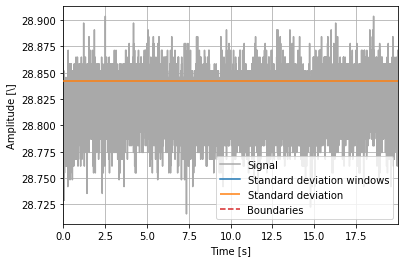

{'index': 0.0, 'bns': 'Non-stationary', 'ind_dw': 100.0, 'ind_up': 100.0}

In [27]:
idns(signal, nsec, sampling_freq, overlap, confidence, Plot)